# **1. Import Library**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV

# **2. Data Preparation**

## **Data Loading**

Untuk dapat mengambil dataset dari Kaggle, perlu dilakukan konfigurasi kredensial API Kaggle di Google Colab. Kaggle menyediakan API yang memungkinkan akses langsung ke dataset mereka tanpa perlu mengunduhnya secara manual.

Proses ini dilakukan dengan mengunggah file kaggle.json yang berisi kredensial API yang diunduh dari halaman akun Kaggle, dan kemudian menyimpannya di folder .kaggle pada Google Colab.

In [2]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"valensiaelsakurnia","key":"c4287404537f6b82f7d127b79d980513"}'}

In [3]:
# Hapus semua folder yang berpotensi bentrok
!rm -rf "anemia-dataset.zip"
!rm -rf "anemia.csv"

# Setup kredensial Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset Anemia Dataset
!kaggle datasets download -d biswaranjanrao/anemia-dataset

# Unzip file dataset
!unzip anemia-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/biswaranjanrao/anemia-dataset
License(s): unknown
Archive:  anemia-dataset.zip
  inflating: anemia.csv              


Dengan kredensial yang telah disiapkan, kode *!kaggle datasets download -d biswaranjanrao/anemia-dataset* digunakan untuk mengunduh dataset yang berjudul "anemia-dataset" dari Kaggle.

Setelah itu, file yang diunduh (dalam format ZIP) diekstrak menggunakan perintah !unzip anemia-dataset.zip. Ekstraksi ini bertujuan untuk mengakses file data dalam format CSV yang ada di dalamnya.

Setelah itu, kita perlu mengubah dataset yang diunduh dalam format CSV ke dalam variabel DataFrame.

In [4]:
# Membaca dataset
df = pd.read_csv("anemia.csv")
df.head()

,Gender,Hemoglobin,MCH,MCHC,MCV,Result
0,1,14.9,22.7,29.1,83.7,0
1,0,15.9,25.4,28.3,72.0,0
2,0,9.0,21.5,29.6,71.2,1
3,0,14.9,16.0,31.4,87.5,0
4,1,14.7,22.0,28.2,99.5,0


Selanjutnya, cek informasi pada dataset dengan fungsi info()

In [5]:
# Menampilkan informasi tentang dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1421 entries, 0 to 1420
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Gender      1421 non-null   int64  
 1   Hemoglobin  1421 non-null   float64
 2   MCH         1421 non-null   float64
 3   MCHC        1421 non-null   float64
 4   MCV         1421 non-null   float64
 5   Result      1421 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 66.7 KB


Dari hasil *df.info()* dapat dilihat bahwa dataset terdiri dari 1421 baris dan 6 kolom. Detail tiap kolom:
- Gender : merupakan jenis kelamin individu (0 = Laki-laki, 1 = Perempuan).
- Hemoglobin : merupakan kadar hemoglobin (protein) dalam sel darah merah.
- MCH : *Mean Corpuscular Hemoglobin* merupakan jumlah rata-rata hemoglobin di dalam satu sel darah merah.
- MCHC : *Mean Corpuscular Hemoglobin Concentration* merupakan konsentrasi rata-rata hemoglobin dalam satu sel darah merah.
- MCV : *Mean Corpuscular Volume* merupakan volume rata-rata sel darah merah.
- Results : merupakan label yang menunjukkan individu menderita anemia atau tidak (0 = Tidak anemia, 1 = Anemia), result adalah fitur target

Semua kolom bertipe data numerik dengan 4 fitur bertipe data float64(Hemoglobin, MCH, MCHC, dan MCV) dan 2 fitur bertipe data int64 (Gender dan Result). Uraian di atas menunjukkan bahwa setiap kolom telah memiliki tipe data yang sesuai dan dikarenakan semua fitur adalah numerik, maka tidak diperlukan encoding untuk pelatihan.

Selanjutnya, dilakukan pengecekan deskripsi statistik data dengan fitur describe().

In [6]:
# Menampilkan statistik deskriptif dari dataset untuk kolom numerik
df.describe()

,Gender,Hemoglobin,MCH,MCHC,MCV,Result
count,1421.000000,1421.000000,1421.000000,1421.000000,1421.000000,1421.000000
mean,0.520760,13.412738,22.905630,30.251232,85.523786,0.436312
std,0.499745,1.974546,3.969375,1.400898,9.636701,0.496102
min,0.000000,6.600000,16.000000,27.800000,69.400000,0.000000
25%,0.000000,11.700000,19.400000,29.000000,77.300000,0.000000
50%,1.000000,13.200000,22.700000,30.400000,85.300000,0.000000
75%,1.000000,15.000000,26.200000,31.400000,94.200000,1.000000
max,1.000000,16.900000,30.000000,32.500000,101.600000,1.000000


Kolom Gender dan Result memiliki distribusi yang cukup seimbang, sementara kolom numerik seperti Hemoglobin, MCH, MCHC, dan MCV menunjukkan variasi yang cukup besar. Variasi yang besar pada kolom Hemoglobin, MCH, MCHC, dan MCV adalah hal yang wajar, mengingat perbedaan kondisi antara individu yang menderita anemia dan yang tidak.

## **Data Cleaning**

Sebelum pengolahan data lebih lanjut, diperlukan pembersihan data terlebih dahulu. Pertama yang akan kita lakukan adalah memeriksa apakah ada missing value.

In [7]:
# Memeriksa missing value
df.isnull().sum()

,0
Gender,0
Hemoglobin,0
MCH,0
MCHC,0
MCV,0
Result,0


Tidak ada missing value untuk setiap kolom sehingga tidak diperlukan penanganan missing value

Setelah itu, kita periksa apakah ada data yang duplikat

In [8]:
# Memeriksa duplikasi data
jumlah_duplikat = df.duplicated().sum()
print(f"Jumlah baris duplikat: {jumlah_duplikat}")

Jumlah baris duplikat: 887


Terdapat 887 baris duplikat pada dataset yang harus dihapus

In [9]:
# Menghapus baris duplikat
df = df.drop_duplicates()
# Memeriksa jumlah baris setelah duplikasi dihapus
print(f"Jumlah baris setelah penghapusan duplikat: {df.shape[0]}")

Jumlah baris setelah penghapusan duplikat: 534


Penghapusan baris duplikat dilakukan dengan *drop_duplicates()* dan sisa data setelah pembersihan baris duplikat adalah 534. Data yang terduplikasi memang cukup banyak, tetapi sisa data yang bersih sebanyak 534 (di atas 500) masih bisa untuk digunakan.

Selanjutnya, kita cek apakah ada outliers

Jumlah Outlier per Kolom:
Gender        0
Hemoglobin    0
MCH           0
MCHC          0
MCV           0
Result        0
dtype: int64


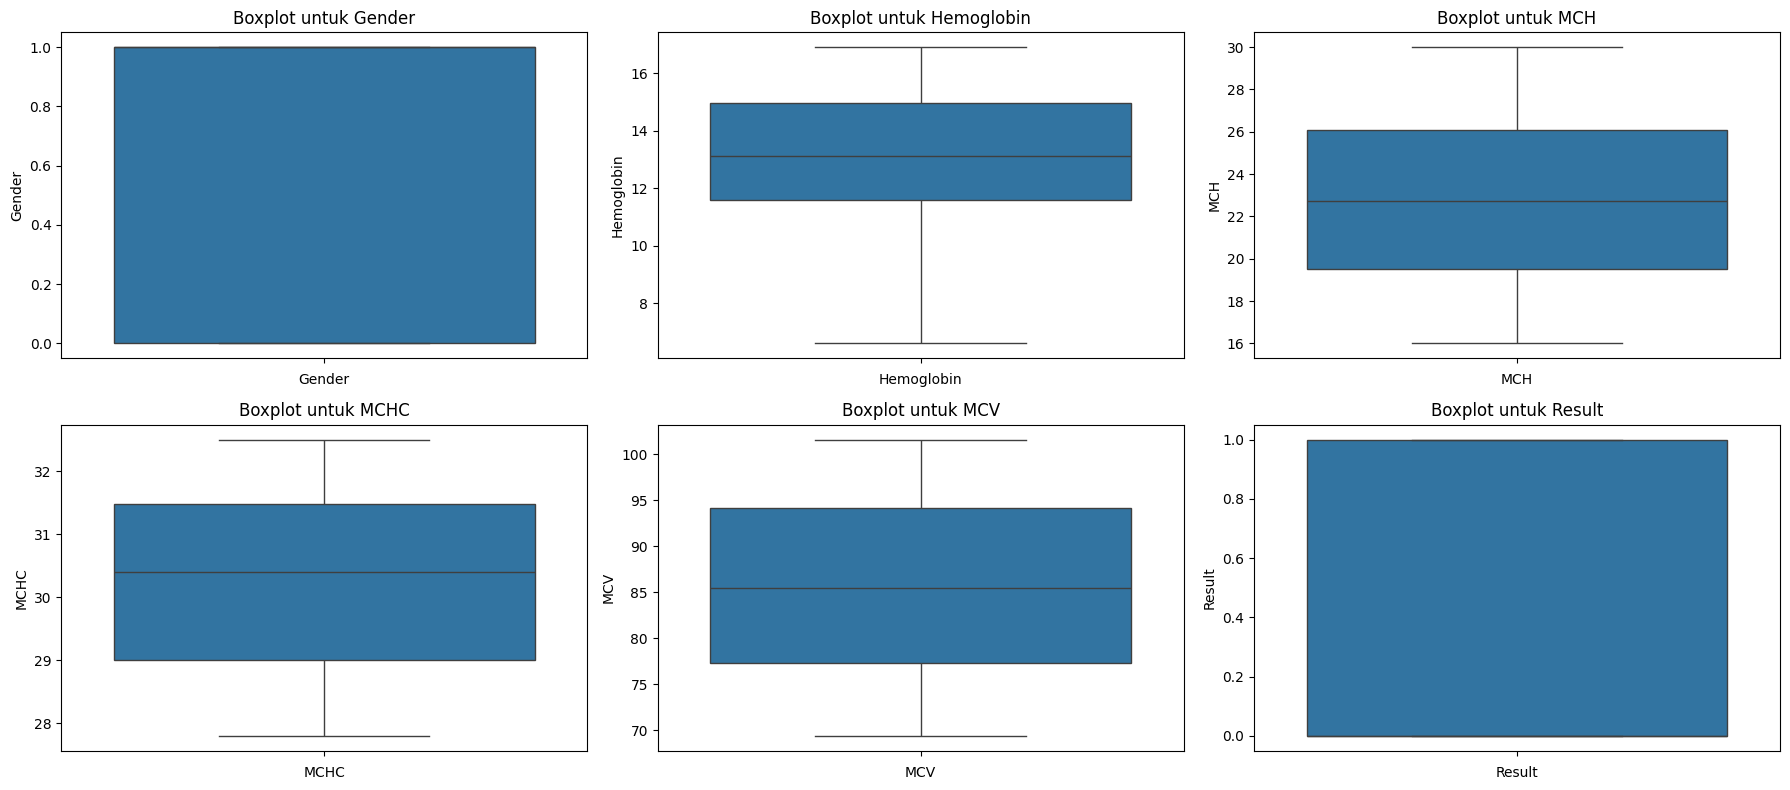

In [10]:
# Menyiapkan kolom yang akan dianalisis (semua kolom numerik)
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Deteksi outlier dengan IQR
Q1 = df[numeric_columns].quantile(0.25)
Q3 = df[numeric_columns].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Menentukan jumlah outlier untuk setiap kolom
outliers = ((df[numeric_columns] < lower_bound) | (df[numeric_columns] > upper_bound)).sum()

# Menampilkan jumlah outlier per kolom
print("Jumlah Outlier per Kolom:")
print(outliers)

# Menentukan jumlah baris dan kolom untuk visualisasi (3 kolom)
n_cols = 3
n_rows = (len(numeric_columns) // n_cols) + (len(numeric_columns) % n_cols > 0)  # Menyesuaikan jumlah baris

# Set canvas ukuran untuk visualisasi
plt.figure(figsize=(n_cols * 6, n_rows * 4))  # Menyesuaikan ukuran figure

# Membuat boxplot untuk setiap kolom numerik
for i, col in enumerate(numeric_columns):
    plt.subplot(n_rows, n_cols, i + 1)  # Membuat grid dengan jumlah baris dan kolom yang disesuaikan
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot untuk {col}")
    plt.xlabel(col)

# Menampilkan plot
plt.tight_layout()
plt.show()

Berdasarkan hasil dari perhitungan outlier menggunakan metode Interquartile Range (IQR), **tidak ada outlier** yang ditemukan pada kolom-kolom dalam dataset ini. Boxplot juga menunjukkan distribusi yang relatif stabil untuk sebagian besar kolom numerik, yang bisa menandakan bahwa **data tidak terdistorsi oleh outlier** atau masalah lain dalam distribusinya.

# **3. Exploratory Data Analysis**

Selanjutnya, kita akan melakukan proses analisis data dengan teknik Univariate, Bivariate, dan Multivariate Analysis.

## **Univariate Analysis**

Fitur Gender dan Result diubah menjadi data kategorikal untuk mempermudah proses EDA

In [11]:
# Mengubah nilai di DataFrame untuk Gender dan Result menjadi kategorikal
df['Gender'] = df['Gender'].replace({0: 'Male', 1: 'Female'})
df['Result'] = df['Result'].replace({0: 'Not Anemic', 1: 'Anemic'})

Kita akan melakukan analisis terhadap fitur kategorikal terlebih dahulu

### **Analisis Distribusi Data Kategorikal**

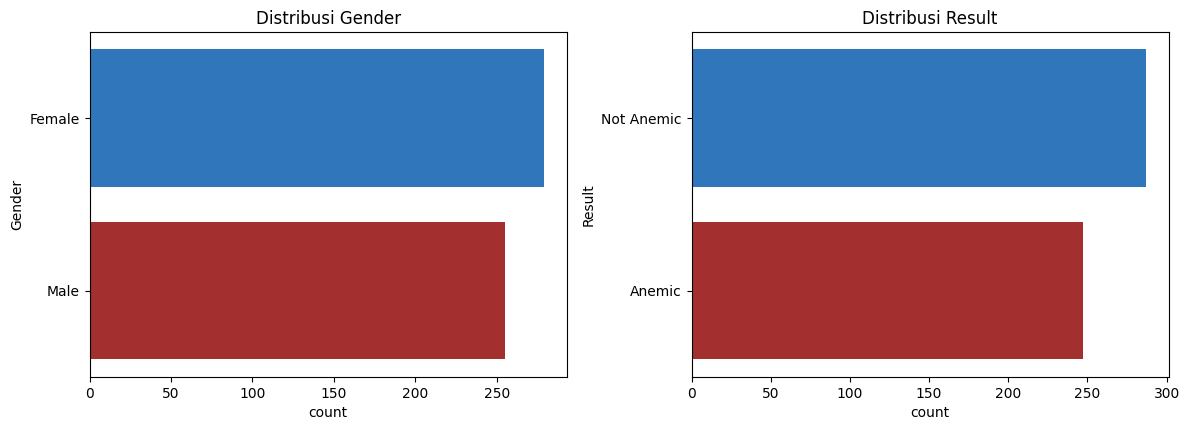

In [12]:
# Pilih kolom kategorikal yang akan dianalisis
categorical_columns = ['Gender', 'Result']

# Set plot size
plt.figure(figsize=(12, 8))

# Buat bar plot horizontal untuk setiap variabel kategorikal
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(2, 2, i)
    if col == 'Gender':
        # Plot untuk Gender dengan warna yang berbeda
        sns.countplot(data=df, y=col, palette=['#1976D2', '#B71C1C'], order=df[col].value_counts().index, hue='Gender')
    else:
        # Plot untuk Result dengan warna yang berbeda
        sns.countplot(data=df, y=col, palette=['#1976D2', '#B71C1C'], order=df[col].value_counts().index, hue='Result')

    plt.title(f"Distribusi {col}")

# Menampilkan plot
plt.tight_layout()
plt.show()

Dari hasil, dapat dilihat bahwa terdapat lebih banyak individu berjenis kelamin Female daripada Male, dengan jumlah Female yang jauh lebih dominan. Distribusi Result menunjukkan bahwa kategori Not Anemic lebih dominan dibandingkan dengan Anemic, dengan jumlah individu yang tidak menderita anemia jauh lebih banyak.

Selanjutnya, lakukan analisis terhadap data numerik

### **Analisis Distribusi Data Numerik**

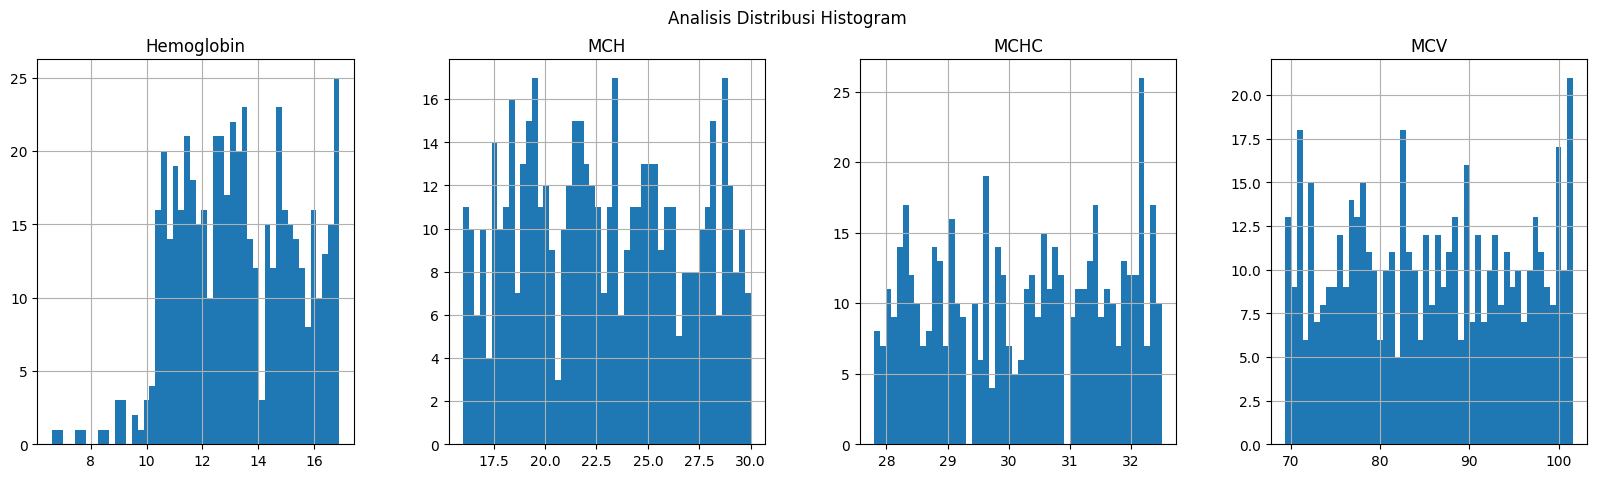

In [13]:
# Menyiapkan kolom yang akan dianalisis
colhist = df.iloc[:, 1:5]  # Kolom dari Hemoglobin, MCH, MCHC, MCV

# Membuat histogram untuk masing-masing kolom dengan menggunakan .hist() dari pandas
colhist.hist(bins=50, figsize=(20, 5), layout=(1, 4))

# Menambahkan judul utama
plt.suptitle("Analisis Distribusi Histogram")

# Menampilkan plot
plt.show()

Dari histogram di atas, dapat dilihat bahwa Hemoglobin cenderung terdistribusi dengan konsentrasi pada nilai rendah dan lonjakan di sekitar 16 (cenderung left-skewed). MCH memiliki distribusi yang lebih merata dengan puncak di kisaran 22-26, sementara MCHC lebih terkonsentrasi pada nilai antara 28-32. MCV menunjukkan variasi yang lebih luas, terutama di kisaran 70 hingga 100.

## **Bivariate Analysis**

Selanjutnya, kita akan menganalisis hubungan antara fitur-fitur terhadap fitur target (Result)

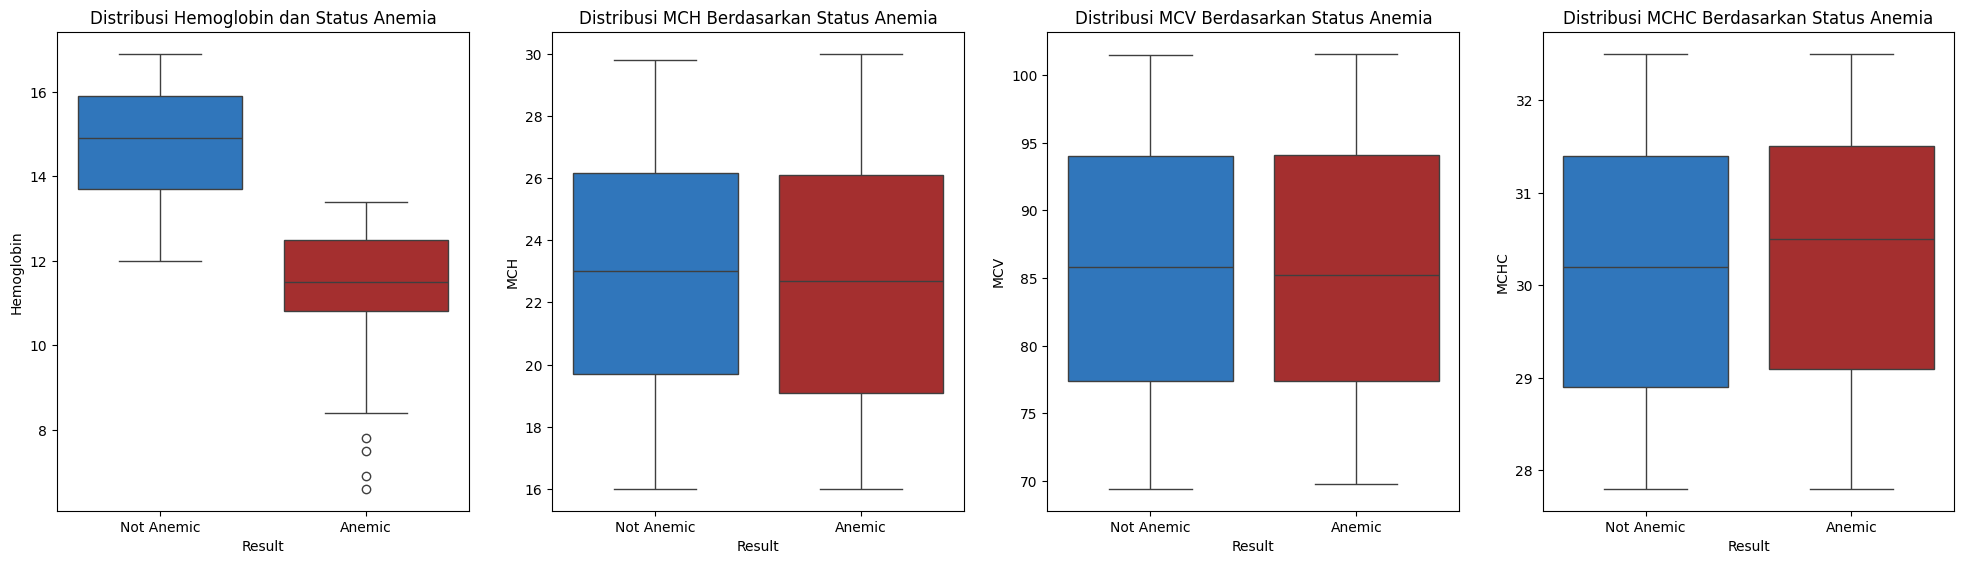

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set ukuran canvas untuk 1 baris, 4 kolom, 4 plot
plt.figure(figsize=(20, 6))

# Plot untuk Hemoglobin
plt.subplot(1, 4, 1)  # 1 baris, 4 kolom, plot pertama
sns.boxplot(data=df, x='Result', y='Hemoglobin', hue='Result', palette={'Not Anemic': '#1976D2', 'Anemic': '#B71C1C'})
plt.title('Distribusi Hemoglobin dan Status Anemia')
plt.xlabel('Result')
plt.ylabel('Hemoglobin')

# Plot untuk MCH
plt.subplot(1, 4, 2)  # 1 baris, 4 kolom, plot kedua
sns.boxplot(data=df, x='Result', y='MCH', hue='Result', palette={'Not Anemic': '#1976D2', 'Anemic': '#B71C1C'})
plt.title('Distribusi MCH Berdasarkan Status Anemia')
plt.xlabel('Result')
plt.ylabel('MCH')

# Plot untuk MCV
plt.subplot(1, 4, 3)  # 1 baris, 4 kolom, plot ketiga
sns.boxplot(data=df, x='Result', y='MCV', hue='Result', palette={'Not Anemic': '#1976D2', 'Anemic': '#B71C1C'})
plt.title('Distribusi MCV Berdasarkan Status Anemia')
plt.xlabel('Result')
plt.ylabel('MCV')

# Plot untuk MCHC
plt.subplot(1, 4, 4)  # 1 baris, 4 kolom, plot keempat
sns.boxplot(data=df, x='Result', y='MCHC', hue='Result', palette={'Not Anemic': '#1976D2', 'Anemic': '#B71C1C'})
plt.title('Distribusi MCHC Berdasarkan Status Anemia')
plt.xlabel('Result')
plt.ylabel('MCHC')

# Menyesuaikan layout
plt.tight_layout(pad=2.0)  # Adjust padding between subplots
plt.show()

Dapat dilihat bahwa individu yang terkena anemia memiliki kadar hemoglobin lebih rendah dibandingkan dengan individu yang tidak terkena anemia. Sedangkan, fitur MCH, MCV, dan MCHC menunjukkan perbedaan kecil antara kelompok Anemic dan Not Anemic, mengindikasikan bahwa perbedaan yang lebih besar mungkin terletak pada fitur Hemoglobin.

## **Multivariate Analysis**

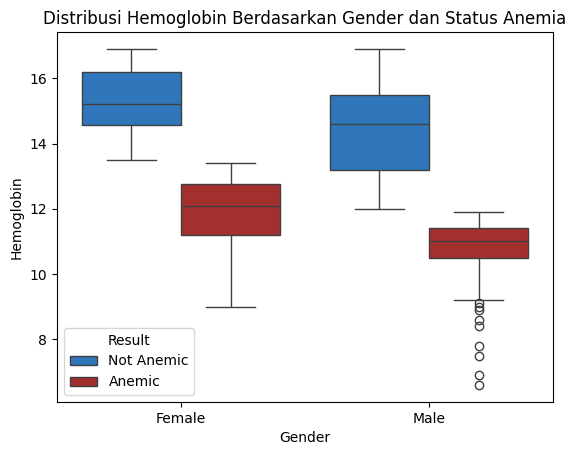

In [15]:
sns.boxplot(data=df, x='Gender', y='Hemoglobin', hue='Result', palette={'Not Anemic': '#1976D2', 'Anemic': '#B71C1C'})
plt.title('Distribusi Hemoglobin Berdasarkan Gender dan Status Anemia')
plt.show()

Pada eksplorasi lebih lanjut, dapat dilihat bahwa perempuan yang menderita anemia (ditandai dengan kotak merah) memiliki kadar Hemoglobin yang lebih rendah dibandingkan dengan laki-laki yang menderita anemia. Selain itu, perempuan yang tidak menderita anemia (kotak biru) menunjukkan kadar Hemoglobin yang lebih tinggi secara keseluruhan dibandingkan laki-laki.

### **Analisis Korelasi**

Fitur Result dan Gender dikembalikan ke tipe data semula (int) karena proses Analisis Distribusi sudah selesai dan pada Analisis Korelasi diperlukan data numerik.

In [16]:
# Ganti nilai pada kolom dengan memetakan kategori menjadi numerik kembali (kembali ke data awal)
df['Gender'] = df['Gender'].replace({'Male': 0, 'Female': 1}).astype(int)
df['Result'] = df['Result'].replace({'Not Anemic': 0, 'Anemic': 1}).astype(int)

<ipython-input-16-6aeb7eb3874a>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Gender'] = df['Gender'].replace({'Male': 0, 'Female': 1}).astype(int)
<ipython-input-16-6aeb7eb3874a>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Result'] = df['Result'].replace({'Not Anemic': 0, 'Anemic': 1}).astype(int)


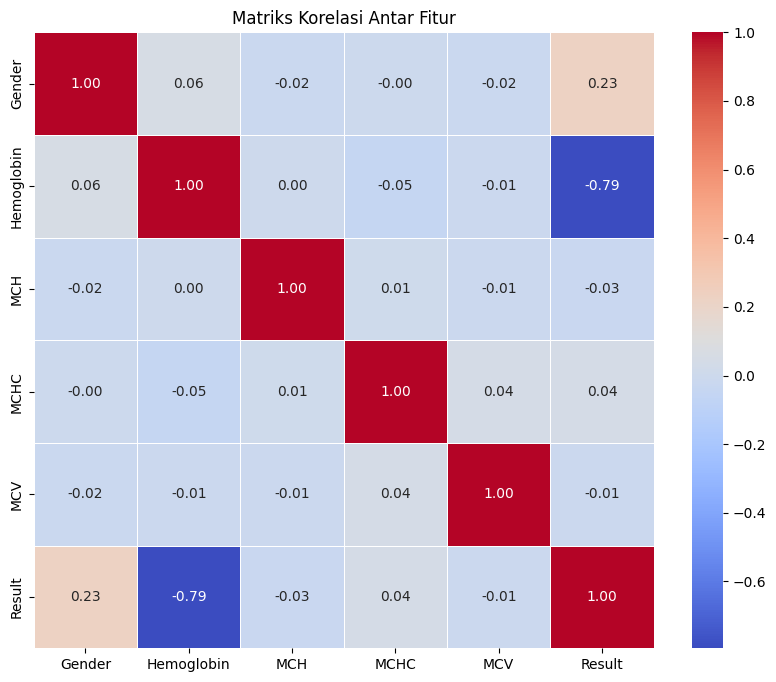

In [17]:
# Menghitung matriks korelasi antar fitur numerik pada DataFrame
correlation_matrix = df.corr()

# Visualisasi heatmap matriks korelasi
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar=True)

# Menambahkan judul pada heatmap
plt.title('Matriks Korelasi Antar Fitur')
plt.show()

Hemoglobin memiliki korelasi negatif yang kuat dengan Result (-0.79), menunjukkan bahwa semakin rendah kadar hemoglobin, semakin besar kemungkinan seseorang menderita anemia. Kolom Gender menunjukkan korelasi positif yang sangat lemah dengan Result (0.23), sementara korelasi antara fitur-fitur seperti MCH, MCHC, dan MCV dengan Result sangat rendah, menunjukkan bahwa mereka mungkin tidak memberikan kontribusi signifikan dalam memprediksi status anemia. Meskipun begitu tidak akan ada fitur yang dihapus mengingat data yang digunakan sedikit.

# **4. Data Preprocessing**

Mengingat semua fitur pada dateset adalah numerik, maka tidak perlu dilakukan encoding.

Langkah awal yang perlu dilakukan adalah membaga dataset menjadi data latih (train) dan data uji (test).

## **Split Dataset**

In [18]:
# Pisahkan fitur (X) dan target (y)
X = df.drop(columns=['Result'])
y = df['Result'].astype(int)

# Split data menjadi set pelatihan dan set uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Menampilkan jumlah data pada masing-masing set
print("Jumlah data pada X_train:", X_train.shape[0])
print("Jumlah data pada X_test:", X_test.shape[0])
print("Jumlah data pada y_train:", y_train.shape[0])
print("Jumlah data pada y_test:", y_test.shape[0])

# Tampilkan bentuk set pelatihan dan set uji untuk memastikan split
print("\nDistribusi kelas pada data pelatihan:\n", y_train.value_counts())
print("\nDistribusi kelas pada data uji:\n", y_test.value_counts())

Jumlah data pada X_train: 427
Jumlah data pada X_test: 107
Jumlah data pada y_train: 427
Jumlah data pada y_test: 107

Distribusi kelas pada data pelatihan:
 Result
0    229
1    198
Name: count, dtype: int64

Distribusi kelas pada data uji:
 Result
0    58
1    49
Name: count, dtype: int64


Data telah dipisahkan menjadi dua set: set pelatihan dan set uji, dengan 80% data digunakan untuk pelatihan dan 20% untuk pengujian. Jumlah data pada set pelatihan (427 data) dan set uji (107 data) telah ditampilkan, memastikan bahwa proporsi data tetap konsisten.

Distribusi kelas pada set pelatihan menunjukkan 229 individu tidak menderita anemia (Result=0) dan 198 individu menderita anemia (Result=1), sedangkan pada set uji, terdapat 58 individu tidak menderita anemia dan 49 individu menderita anemia.

## **Penanganan Imbalance Class**

Pada EDA, diketahui terdapat ketidakseimbangan kelas antara Anemic dan Not Anemic. Oleh karena itu, dilakukan penanganan untuk menyeimbangkan kelas menggunakan SMOTE.

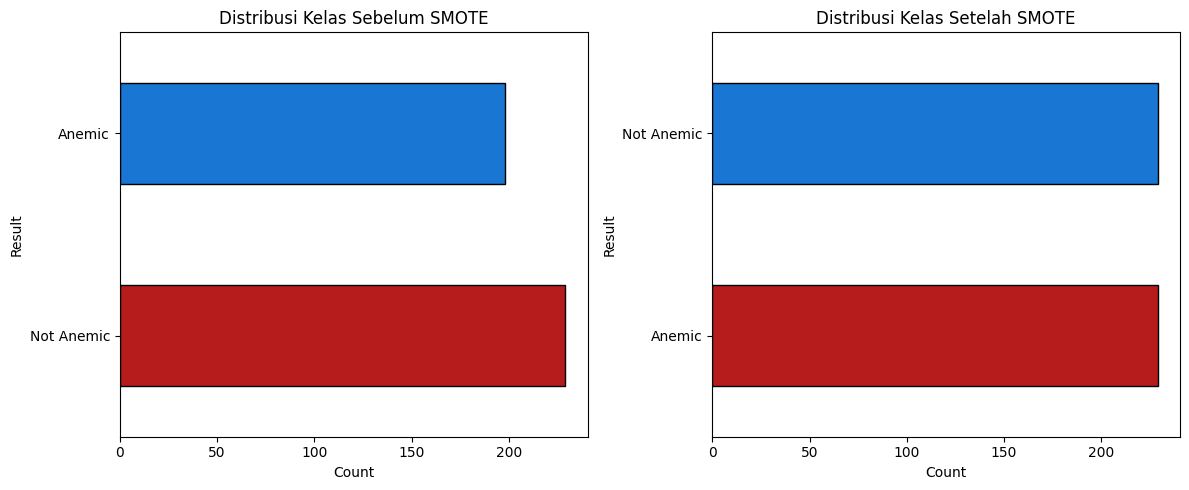

In [19]:
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Penanganan imbalance class dengan SMOTE (hanya di training set)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Mengganti label angka dengan kategori
y_train_labels = y_train.map({0: 'Not Anemic', 1: 'Anemic'})
y_train_resampled_labels = y_train_resampled.map({0: 'Not Anemic', 1: 'Anemic'})

# Plot distribusi kelas sebelum SMOTE
plt.figure(figsize=(12, 5))

# Plot pertama untuk sebelum SMOTE
plt.subplot(1, 2, 1)
y_train_labels.value_counts().plot.barh(color=['#B71C1C', '#1976D2'], edgecolor='black')
plt.title('Distribusi Kelas Sebelum SMOTE')
plt.xlabel('Count')
plt.ylabel('Result')

# Plot kedua untuk setelah SMOTE
plt.subplot(1, 2, 2)
y_train_resampled_labels.value_counts().plot.barh(color=['#B71C1C', '#1976D2'], edgecolor='black')
plt.title('Distribusi Kelas Setelah SMOTE')
plt.xlabel('Count')
plt.ylabel('Result')

# Menampilkan plot
plt.tight_layout()
plt.show()


Setelah dilakukan SMOTE, dapat terlihat data antara anemic dan not anemic menjadi seimbang.

## **Standarisasi**

Pada tahap ini, dilakukan standarisasi pada data X_train_resampled menggunakan StandardScaler. Proses ini memastikan bahwa setiap fitur dalam data memiliki distribusi dengan rata-rata 0 dan standar deviasi 1.

In [20]:
# Standarisasi data (hanya di training set)
scaler = StandardScaler()

# Fit dan transform data pelatihan
X_train_scaled = scaler.fit_transform(X_train_resampled)

# Transform data uji menggunakan scaler yang sama
X_test_scaled = scaler.transform(X_test)

# Menampilkan contoh data setelah standarisasi
print("Contoh data X_train setelah standarisasi:\n", X_train_scaled[:5])

Contoh data X_train setelah standarisasi:
 [[ 0.99130418 -0.33298437  0.59832174  0.8724921   0.63036238]
 [-1.0087721  -1.39349073 -0.71413695 -1.4734584   0.07072945]
 [ 0.99130418  0.29367849 -0.50826108  0.65922388  1.22108603]
 [ 0.99130418 -0.81503272 -0.37958866 -1.11801135  1.3454489 ]
 [ 0.99130418  0.8721365  -0.30238521  0.23268742  0.45418164]]


Hasil dari standarisasi terlihat pada output, di mana nilai-nilai fitur yang sebelumnya memiliki rentang berbeda sekarang memiliki skala yang seragam, yang penting untuk model yang sensitif terhadap skala data, seperti KNN.

Setelah melewati tahap data preparation, data siap untuk digunakan dalam pembangunan model

# **5. Pembangunan Model**

## **a. Membangun Model Klasifikasi**

Setiap algoritma klasifikasi dilatih secara terpisah menggunakan data pelatihan. Model RandomForestClassifier, DecisionTreeClassifier, Logistic Regression, KNeighborsClassifier, dikonfigurasi dan dilatih sesuai dengan dataset yang tersedia.

In [31]:
rf = RandomForestClassifier().fit(X_train_scaled, y_train_resampled)
dt = DecisionTreeClassifier().fit(X_train_scaled, y_train_resampled)
lr = LogisticRegression().fit(X_train_scaled, y_train_resampled)
knn = KNeighborsClassifier().fit(X_train_scaled, y_train_resampled)
print("Model training selesai.")

Model training selesai.


Setelah proses pelatihan selesai, model-model ini siap diuji menggunakan data uji. Pesan "Model training selesai." menunjukkan bahwa seluruh model telah berhasil melewati tahap pelatihan dan siap untuk evaluasi.

## **b. Evaluasi Model Klasifikasi**

Kemudian kita melakukan evaluasi awal model sebelum hyperparameter tuning

In [32]:
# Fungsi untuk evaluasi model
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)  # Confusion matrix

    results = {
        'Confusion Matrix': cm,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred, average='weighted'),
        'Classification Report': classification_report(y_test, y_pred)
    }

    # Plot Confusion Matrix
    plot_confusion_matrix(cm, model_name)

    return results

# Fungsi untuk menampilkan Confusion Matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


Model: Random Forest (RF)


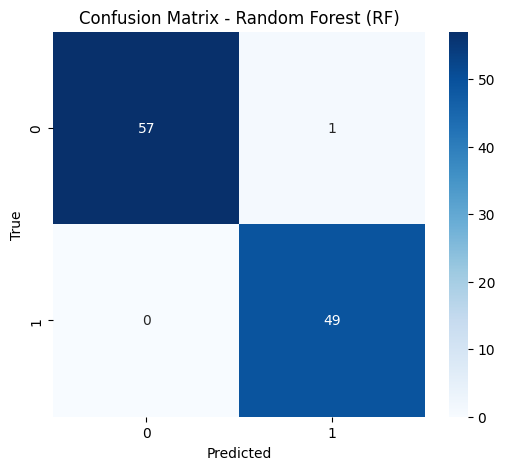

Accuracy: 0.9907
Precision: 0.9908
Recall: 0.9907
F1-Score: 0.9907

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        58
           1       0.98      1.00      0.99        49

    accuracy                           0.99       107
   macro avg       0.99      0.99      0.99       107
weighted avg       0.99      0.99      0.99       107


Model: Decision Tree (DT)


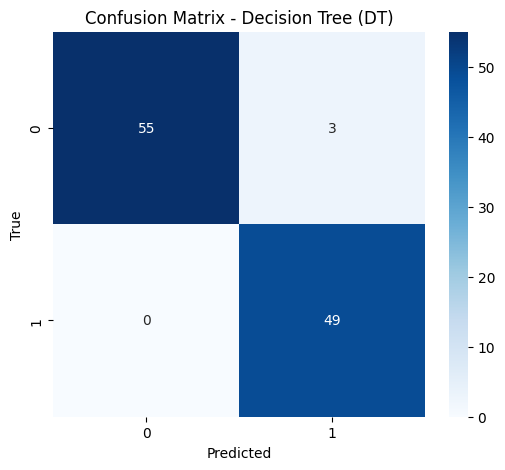

Accuracy: 0.9720
Precision: 0.9736
Recall: 0.9720
F1-Score: 0.9720

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        58
           1       0.94      1.00      0.97        49

    accuracy                           0.97       107
   macro avg       0.97      0.97      0.97       107
weighted avg       0.97      0.97      0.97       107


Model: Logistic Regression (LR)


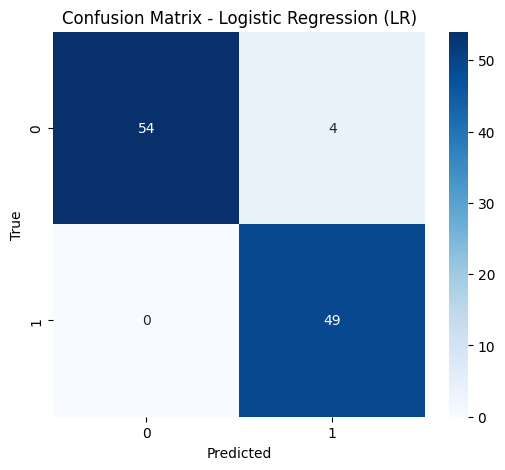

Accuracy: 0.9626
Precision: 0.9654
Recall: 0.9626
F1-Score: 0.9627

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        58
           1       0.92      1.00      0.96        49

    accuracy                           0.96       107
   macro avg       0.96      0.97      0.96       107
weighted avg       0.97      0.96      0.96       107


Model: K-Nearest Neighbors (KNN)


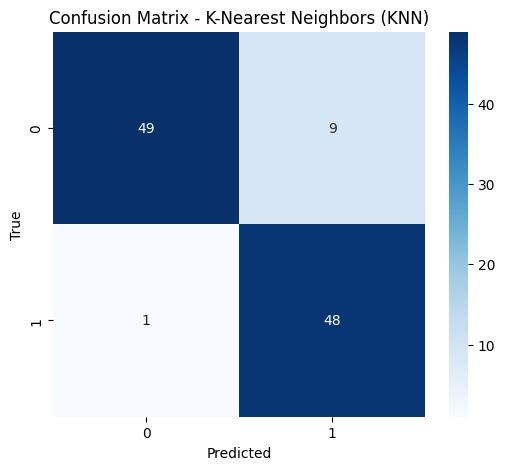

Accuracy: 0.9065
Precision: 0.9169
Recall: 0.9065
F1-Score: 0.9066

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.84      0.91        58
           1       0.84      0.98      0.91        49

    accuracy                           0.91       107
   macro avg       0.91      0.91      0.91       107
weighted avg       0.92      0.91      0.91       107

                       Model  Accuracy  Precision    Recall  F1-Score
0         Random Forest (RF)  0.990654   0.990841  0.990654  0.990661
1         Decision Tree (DT)  0.971963   0.973580  0.971963  0.972007
2   Logistic Regression (LR)  0.962617   0.965438  0.962617  0.962682
3  K-Nearest Neighbors (KNN)  0.906542   0.916852  0.906542  0.906607


In [33]:
# Model yang akan diuji
models = {
    'Random Forest (RF)': rf,
    'Decision Tree (DT)': dt,
    'Logistic Regression (LR)': lr,
    'K-Nearest Neighbors (KNN)': knn,
}

# Inisialisasi dictionary hasil evaluasi
results = {}

# Evaluasi semua model
for model_name, model in models.items():
    print(f"\nModel: {model_name}")
    results[model_name] = evaluate_model(model, X_test_scaled, y_test, model_name)
    print(f"Accuracy: {results[model_name]['Accuracy']:.4f}")
    print(f"Precision: {results[model_name]['Precision']:.4f}")
    print(f"Recall: {results[model_name]['Recall']:.4f}")
    print(f"F1-Score: {results[model_name]['F1-Score']:.4f}")
    print("\nClassification Report:")
    print(results[model_name]['Classification Report'])
    print("="*60)

# Buat DataFrame untuk meringkas hasil
summary_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Isi DataFrame dengan hasil evaluasi
rows = []
for model_name, metrics in results.items():
    rows.append({
        'Model': model_name,
        'Accuracy': metrics['Accuracy'],
        'Precision': metrics['Precision'],
        'Recall': metrics['Recall'],
        'F1-Score': metrics['F1-Score']
    })

# Konversi daftar hasil ke DataFrame
summary_df = pd.DataFrame(rows)

# Tampilkan hasil ringkasan
print(summary_df)

Secara keseluruhan, **Random Forest** menjadi model yang paling unggul dalam hal akurasi, recall, dan keseimbangan metrik evaluasi, diikuti oleh **Decision Tree**, **Logistic Regression**, dan **K-Nearest Neighbors**. Model ini memberikan wawasan mengenai fitur yang paling relevan dan memberikan hasil yang optimal pada dataset yang diuji.


## **c. Tuning Model Klasifikasi**

Menggunakan GridSearchCV untuk mencari kombinasi hyperparameter terbaik untuk setiap model dan menyimpannya.

### Random Forest

In [23]:
# Menyiapkan parameter grid untuk tuning RF
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Menyiapkan GridSearchCV
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5)

# Melakukan fitting GridSearchCV
grid_rf.fit(X_train_scaled, y_train_resampled)

# Menampilkan hasil terbaik
print("Best Params for Random Forest:", grid_rf.best_params_)

# Mendapatkan model terbaik
best_rf = grid_rf.best_estimator_

Best Params for Random Forest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}


### Decision Tree

In [24]:
# Menyiapkan parameter grid untuk tuning DT
param_grid_dt = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Menyiapkan GridSearchCV
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5)

# Melakukan fitting GridSearchCV
grid_dt.fit(X_train_scaled, y_train_resampled)

# Menampilkan hasil terbaik
print("Best Params for Decision Tree:", grid_dt.best_params_)

# Mendapatkan model terbaik
best_dt = grid_dt.best_estimator_

Best Params for Decision Tree: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5}


### Logistic Regression

In [25]:
# Menyiapkan parameter grid untuk tuning LR
param_grid_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1],
    'solver': ['liblinear', 'saga'],
}

# Menyiapkan GridSearchCV
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5)

# Melakukan fitting GridSearchCV
grid_lr.fit(X_train_scaled, y_train_resampled)

# Menampilkan hasil terbaik
print(f"Best params for Logistic Regression:", grid_lr.best_params_)

# Mendapatkan model terbaik
best_lr = grid_lr.best_estimator_

Best params for Logistic Regression: {'C': 1, 'penalty': 'l1', 'solver': 'saga'}


### K-Nearest Neighbors

In [26]:
# Menyiapkan parameter grid untuk tuning KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Menyiapkan GridSearchCV
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5)

# Melakukan fitting GridSearchCV
grid_knn.fit(X_train_scaled, y_train_resampled)

# Menampilkan hasil terbaik
print("Best Params for KNN:", grid_knn.best_params_)

# Mendapatkan model terbaik
best_knn = grid_knn.best_estimator_

Best Params for KNN: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}


In [27]:
# Menyusun hasil terbaik dalam bentuk summary
results_summary = {
    'Random Forest (RF)': grid_rf.best_params_,
    'Decision Tree (DT)': grid_dt.best_params_,
    'Logistic Regression (LR)': grid_lr.best_params_,
    'K-Nearest Neighbors (KNN)': grid_knn.best_params_
}

# Menampilkan summary hasil best parameters
print("Summary of Best Parameters for Each Model:")
for model_name, best_params in results_summary.items():
    print(f"\n{model_name}:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")

Summary of Best Parameters for Each Model:

Random Forest (RF):
  max_depth: 10
  min_samples_split: 2
  n_estimators: 200

Decision Tree (DT):
  criterion: gini
  max_depth: 5
  min_samples_split: 5

Logistic Regression (LR):
  C: 1
  penalty: l1
  solver: saga

K-Nearest Neighbors (KNN):
  metric: euclidean
  n_neighbors: 5
  weights: uniform


## **d. Evaluasi Model Klasifikasi Setelah Tunning**

Setelah menemukan kombinasi parameter terbaik, model dievaluasi ulang untuk melihat perbandingan performa.


Model: Random Forest (RF)


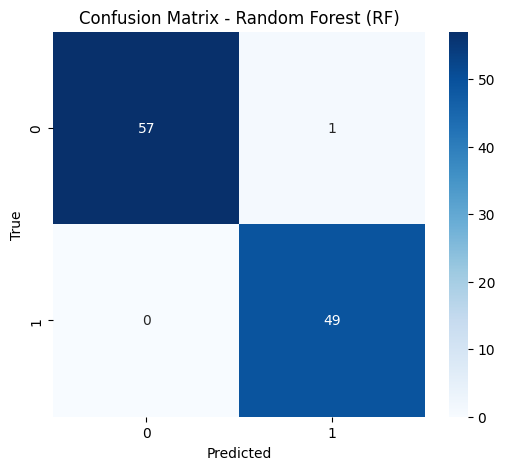

Accuracy: 0.9907
Precision: 0.9908
Recall: 0.9907
F1-Score: 0.9907

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        58
           1       0.98      1.00      0.99        49

    accuracy                           0.99       107
   macro avg       0.99      0.99      0.99       107
weighted avg       0.99      0.99      0.99       107


Model: Decision Tree (DT)


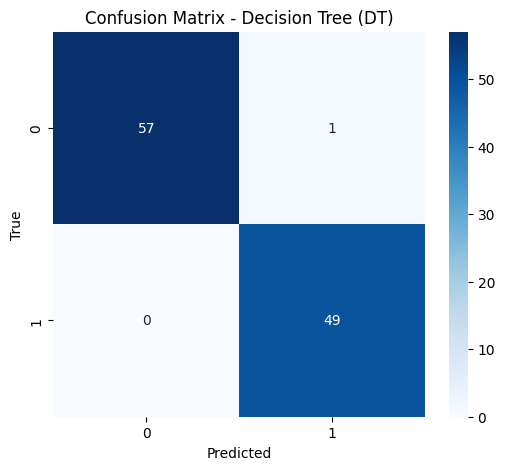

Accuracy: 0.9907
Precision: 0.9908
Recall: 0.9907
F1-Score: 0.9907

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        58
           1       0.98      1.00      0.99        49

    accuracy                           0.99       107
   macro avg       0.99      0.99      0.99       107
weighted avg       0.99      0.99      0.99       107


Model: Logistic Regression (LR)


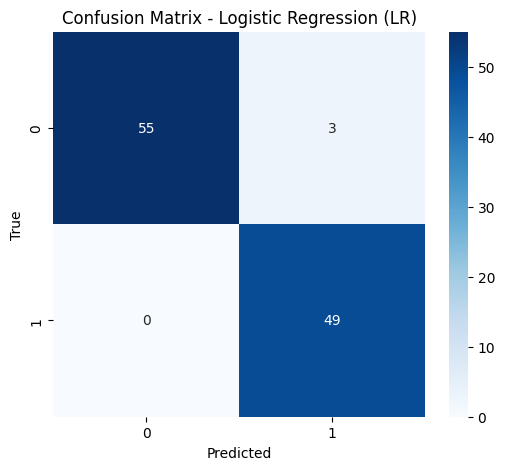

Accuracy: 0.9720
Precision: 0.9736
Recall: 0.9720
F1-Score: 0.9720

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        58
           1       0.94      1.00      0.97        49

    accuracy                           0.97       107
   macro avg       0.97      0.97      0.97       107
weighted avg       0.97      0.97      0.97       107


Model: K-Nearest Neighbors (KNN)


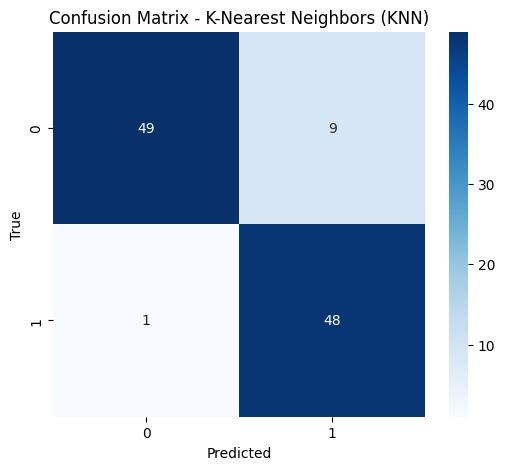

Accuracy: 0.9065
Precision: 0.9169
Recall: 0.9065
F1-Score: 0.9066

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.84      0.91        58
           1       0.84      0.98      0.91        49

    accuracy                           0.91       107
   macro avg       0.91      0.91      0.91       107
weighted avg       0.92      0.91      0.91       107

                       Model  Accuracy  Precision    Recall  F1-Score
0         Random Forest (RF)  0.990654   0.990841  0.990654  0.990661
1         Decision Tree (DT)  0.990654   0.990841  0.990654  0.990661
2   Logistic Regression (LR)  0.971963   0.973580  0.971963  0.972007
3  K-Nearest Neighbors (KNN)  0.906542   0.916852  0.906542  0.906607


In [28]:
# Model yang akan diuji
models = {
    'Random Forest (RF)': best_rf,
    'Decision Tree (DT)': best_dt,
    'Logistic Regression (LR)': best_lr,
    'K-Nearest Neighbors (KNN)': best_knn,
}

# Inisialisasi dictionary hasil evaluasi
results_after_tuning = {}

# Evaluasi semua model
for model_name, model in models.items():
    print(f"\nModel: {model_name}")
    results_after_tuning[model_name] = evaluate_model(model, X_test_scaled, y_test, model_name)
    print(f"Accuracy: {results_after_tuning[model_name]['Accuracy']:.4f}")
    print(f"Precision: {results_after_tuning[model_name]['Precision']:.4f}")
    print(f"Recall: {results_after_tuning[model_name]['Recall']:.4f}")
    print(f"F1-Score: {results_after_tuning[model_name]['F1-Score']:.4f}")
    print("\nClassification Report:")
    print(results_after_tuning[model_name]['Classification Report'])
    print("="*60)

# Buat DataFrame untuk meringkas hasil
summary_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Isi DataFrame dengan hasil evaluasi
rows = []
for model_name, metrics in results_after_tuning.items():
    rows.append({
        'Model': model_name,
        'Accuracy': metrics['Accuracy'],
        'Precision': metrics['Precision'],
        'Recall': metrics['Recall'],
        'F1-Score': metrics['F1-Score']
    })

# Konversi daftar hasil ke DataFrame
summary_df = pd.DataFrame(rows)

# Tampilkan hasil ringkasan
print(summary_df)

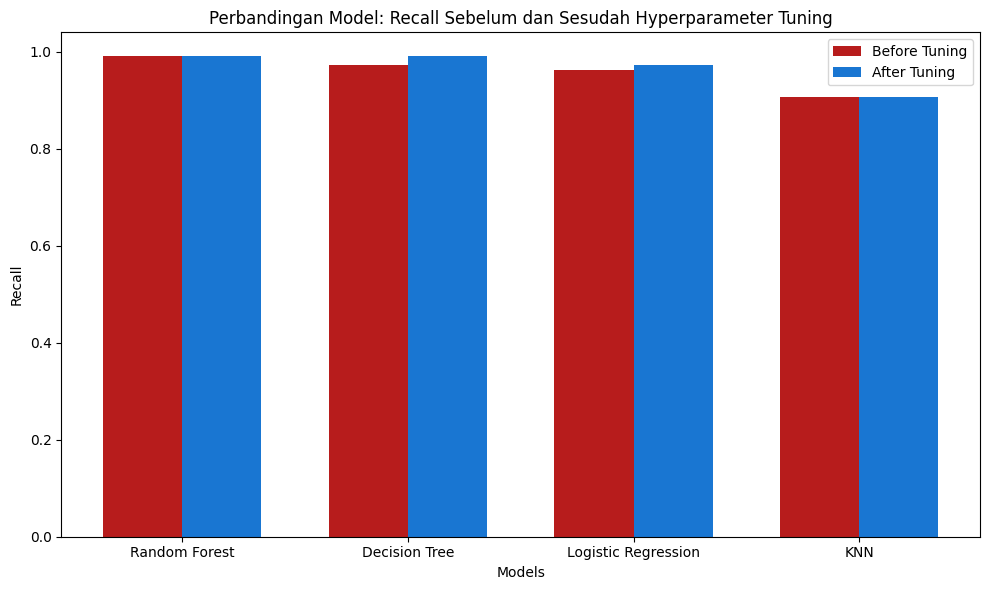

In [34]:
import matplotlib.pyplot as plt

# Hasil evaluasi Recall sebelum tuning
before_tuning_recall = [
    results['Random Forest (RF)']['Recall'],
    results['Decision Tree (DT)']['Recall'],
    results['Logistic Regression (LR)']['Recall'],
    results['K-Nearest Neighbors (KNN)']['Recall']
]

# Hasil evaluasi Recall setelah tuning
after_tuning_recall = [
    results_after_tuning['Random Forest (RF)']['Recall'],
    results_after_tuning['Decision Tree (DT)']['Recall'],
    results_after_tuning['Logistic Regression (LR)']['Recall'],
    results_after_tuning['K-Nearest Neighbors (KNN)']['Recall']
]

# Model names
models = ['Random Forest', 'Decision Tree', 'Logistic Regression', 'KNN']

# Membuat grafik batang untuk perbandingan Recall
x = range(len(models))
fig, ax = plt.subplots(figsize=(10, 6))

# Bar width
bar_width = 0.35

# Plot sebelum tuning
ax.bar(x, before_tuning_recall, bar_width, label='Before Tuning', color='#B71C1C')

# Plot setelah tuning
ax.bar([p + bar_width for p in x], after_tuning_recall, bar_width, label='After Tuning', color='#1976D2')

# Menambahkan judul dan label
ax.set_title('Perbandingan Model: Recall Sebelum dan Sesudah Hyperparameter Tuning')
ax.set_xlabel('Models')
ax.set_ylabel('Recall')
ax.set_xticks([p + bar_width/2 for p in x])
ax.set_xticklabels(models)

# Menambahkan legenda
ax.legend()

# Menampilkan grafik
plt.tight_layout()
plt.show()


Ada sedikit peningkatan hasil evaluasi setelah dilakukan hyperparameter tuning

Secara keseluruhan, **Random Forest** tetap menjadi model yang paling disarankan setelah tuning dengan nilai Recall yang sangat tinggi dan metrik evaluasi lainnya yang juga tinggi, diikuti oleh Decision Tree, dengan Logistic Regression dan KNN lebih cocok digunakan dalam skenario yang lebih sederhana. **Recall** yang tinggi sangat diinginkan dalam kasus diagnosis medis, karena **lebih penting** untuk **menangkap semua pasien yang menderita anemia** (mencegah **false negatives**) daripada menghindari beberapa **false positives**. Dalam konteks ini, **false negatives** (pasien yang seharusnya didiagnosis anemia tetapi tidak terdeteksi) dapat berakibat fatal karena pasien tersebut tidak menerima perawatan yang diperlukan. Oleh karena itu, model dengan **Recall** yang lebih tinggi, seperti **Random Forest**, sangat diutamakan untuk memastikan bahwa sebanyak mungkin individu yang menderita anemia dapat terdeteksi dan diberi penanganan yang tepat.

